In [1]:
import os
import json
import numpy as np
from rdkit import Chem

from matplotlib import pyplot as plt
from itertools import islice
import pandas as pd
import re
from sklearn import metrics
from scipy import stats

In [2]:
datapath = "G:\\Dev\\Data"

gnps_dir = datapath + os.sep + "GNPS For Family"
gnps_5770_dir = datapath + os.sep + "GNPS"
json_file_dir = datapath + os.sep + "trees_gnps"

fragments_occurences = datapath + os.sep + "fragment_occurences.csv"
losses_occurences = datapath + os.sep + "losses_occurences.csv"

csipath = "G:\\Dev\\CSIFingerID\\"
sample_fingerprints_legend_path = csipath + "fingerprints.csv"
output_file_dir = csipath + "all_sirius_output_minibatches"
mgf_batches_input = csipath + "ALL_GNPS_20181012_mini_batches"

fingerprints_path = datapath + os.sep + "1000" + os.sep + "GNPS Python Master" + os.sep + "Final Fingerprints.txt"

assigned_tree_path = datapath + os.sep + "assigned_tree_final.pkl"
assigned_tree_known_ionization_path = datapath + os.sep + "assigned_tree_final_known_ionization.pkl"

In [3]:
fragments_df = pd.read_csv(fragments_occurences, names=["formula", "occurences"])
fragments_df = fragments_df.set_index("formula")
losses_df = pd.read_csv(losses_occurences, names=["formula", "occurences"])
losses_df = losses_df.set_index("formula")

In [4]:
losses_df.index = [index + "_loss" for index in losses_df.index]
print(losses_df.index)
combined_index = fragments_df.index.union(losses_df.index)
print(combined_index)

Index(['CO_loss', 'H2O_loss', 'C2H2_loss', 'CH3_loss', 'CHN_loss', 'CH4_loss',
       'H3N_loss', 'H2_loss', 'C2H4_loss', 'C2H2O_loss',
       ...
       'C3H8S_loss', 'OP_loss', 'CH2N3_loss', 'C7H7NO3_loss', 'O2P_loss',
       'C2H5NOS_loss', 'C10H4N3_loss', 'C9H17O3_loss', 'C3H7N4_loss',
       'C4H6NO2_loss'],
      dtype='object', length=892)
Index(['BrH_loss', 'Br_loss', 'C10', 'C10H10', 'C10H10ClN', 'C10H10ClNO',
       'C10H10ClNO2', 'C10H10F2O2', 'C10H10FN', 'C10H10N',
       ...
       'O2_loss', 'O3S_loss', 'O3_loss', 'O4_loss', 'O5_loss', 'OP_loss',
       'OS_loss', 'O_loss', 'S2_loss', 'S_loss'],
      dtype='object', length=5508)


In [5]:
spectrum_smiles = {}
spectrum_formula = {}

for file in os.listdir(gnps_dir):
    filepath = os.path.join(gnps_dir, file)
    with open(filepath, 'r') as f:
        content = f.readlines()
        smiles = content[6].split(" ")[1][:-1]
        formula = content[1].split(" ")[1][:-1]
        mol_name = file[:-3]
        spectrum_smiles[mol_name] = smiles
        spectrum_formula[mol_name] = formula

In [6]:
def file_has_fingerprint(file_content):
    return "fingerprints.csv" in file_content

def file_incomplete(file_content):
    return len(file_content) <= 2

def retrieve_fingerprint_file(formula, folder):
    content = os.listdir(folder)
    return next((filename for filename in content if formula in filename), None)

In [7]:
def load_fingerprints(mol_ids, fingerprint_smarts):
    fingerprints = pd.DataFrame(0, index=mol_ids, columns=range(154), dtype=int)
    for index in fingerprints.index:
        if index in spectrum_smiles:
            smiles = spectrum_smiles[index]
            m = Chem.MolFromSmiles(smiles)
            for i, smarts in enumerate(fingerprint_smarts):
                patt = Chem.MolFromSmarts(smarts)
                fingerprints.at[index, i] = int(m.HasSubstructMatch(patt))
            
    return fingerprints

def load_csi_fingerprints(output_file_dir, mol_folder_file):
    mol_ids = [entry[1] for entry in mol_folder_file]
    fingerprints = pd.DataFrame(0, index=mol_ids, columns=range(154), dtype=float)
    for directory, mol, formula, fpt_file in mol_folder_file:
        file_dir = os.path.join(output_file_dir, directory)
        folder = "1_{0}_{1}".format(directory, mol)
        fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
        fingerprint_file = os.listdir(fingerprints_file_dir)[0]
        full_fingerprint_filepath = os.path.join(fingerprints_file_dir, fingerprint_file)
        with open(full_fingerprint_filepath, 'r') as f:
            content = f.readlines()
            rel_content = content[:154]
            for index, prediction in enumerate(rel_content):
                fingerprints.at[mol, index] = float(prediction[:-1])

    return fingerprints

In [8]:
desc_list = []

with open(sample_fingerprints_legend_path, 'r') as f:
    for line in f:
        rel_index, abs_index, desc = line.split("\t")
        if desc[:-1] != "description":
            desc_list.append(desc[:-1])

desc_list = desc_list[:154]
fingerprint_smarts = [entry.split(" ")[0] for entry in desc_list]

In [9]:
correct_folder_file = []
wrong_folder_file = []
no_fingerprints_folder_file = []

for directory in os.listdir(output_file_dir):
    file_dir = os.path.join(output_file_dir, directory)
    files_in_output_dir = os.listdir(file_dir)
    if file_has_fingerprint(files_in_output_dir):
        mol = files_in_output_dir[1].split("_")[-1]
        folder = "1_{0}_{1}".format(directory, mol)
        fingerprints_file_dir = os.path.join(os.path.join(file_dir, folder), "fingerprints")
        if mol in spectrum_formula:
            formula = spectrum_formula[mol]
            file = retrieve_fingerprint_file(formula, fingerprints_file_dir)
            if file:
                correct_folder_file.append((directory, mol, formula, file))
            else:
                wrong_folder_file.append((directory, mol, formula, os.listdir(fingerprints_file_dir)[0]))
    else:
        if len(os.listdir(file_dir)) > 2:
            index, dir_name, mol_name = os.listdir(file_dir)[1].split("_")
            no_fingerprints_folder_file.append((directory, mol_name))
        
print(len(correct_folder_file))
print(len(wrong_folder_file))
print(len(no_fingerprints_folder_file))

25
56
219


In [10]:
wrong_mol_names = [folder_file[1] for folder_file in wrong_folder_file]
correct_mol_names = [folder_file[1] for folder_file in correct_folder_file]
no_fingerprints_mol_names = [folder_file[1] for folder_file in no_fingerprints_folder_file]

Train our final model

In [11]:
component_set = set()

for formula in combined_index:
    pure_formula = formula.split('_loss')
    components = re.findall('[A-Z][^A-Z\d]*', pure_formula[0])
    for component in components:
        component_set.add(component)

mol_mass = {'C': 12.00000000000, 'H': 1.00782503214, 'O': 15.99491462210, 'N': 14.00307400524,
            'P': 30.97376151200, 'S': 31.97207069000, 'Cl': 34.96885271000, 'I': 126.904468, 'Br': 78.9183376,
            'Si': 27.9769265327, 'F': 18.99840320500, 'D': 2.01410177800}

ion_mass = {'H': 1.007276, 'Na': 22.989218, 'K': 38.963158}

def get_number(string):
    num = 1
    num_in_string = re.findall("[\d]+", string)
    if len(num_in_string) > 0:
        num = int(num_in_string[0])
    return num

def get_string(string):
    return re.findall("[^\d]+", string)[0]  

def get_molecular_mass(formula):
    mass = 0.0
    segments = re.findall('[A-Z][a-z]*[0-9]*', formula)
    for segment in segments:
        mass += mol_mass[get_string(segment)] * get_number(segment)
    
    return mass

fragment_mass_to_formula_dict = {}
loss_mass_to_formula_dict = {}

for formula in fragments_df.index:
    mass = get_molecular_mass(formula)
    mass_int, decimals = str(mass).split(".")
    if mass_int not in fragment_mass_to_formula_dict:
        fragment_mass_to_formula_dict[int(mass_int)] = {}
    fragment_mass_to_formula_dict[int(mass_int)][float(mass)] = formula
    
for formula in losses_df.index:
    pure_formula = formula.split('_loss')
    mass = get_molecular_mass(pure_formula[0])
    mass_int, decimals = str(mass).split(".")
    if mass_int not in loss_mass_to_formula_dict:
        loss_mass_to_formula_dict[int(mass_int)] = {}
    loss_mass_to_formula_dict[int(mass_int)][float(mass)] = pure_formula[0]

In [12]:
def subtract_formula(a, b):
    string = ""
    a_segments = re.findall('[A-Z][a-z]*[0-9]*', a)
    b_segments = re.findall('[A-Z][a-z]*[0-9]*', b)

    a_segment_count = [(get_string(a_segment), get_number(a_segment)) for a_segment in a_segments]

    for b_segment in b_segments:
        for index, a_segment in enumerate(a_segment_count):
            if a_segment[0] == get_string(b_segment):
                a_segment_count[index] = (a_segment[0], a_segment[1] - get_number(b_segment))

    for component, amount in a_segment_count:
        if amount != 0:
            if amount == 1:
                amount = ""
            string += component + str(amount)

    return string

In [13]:
def assign_between_bins(value, bins):
    if len(bins) == 2:
        bin1, bin2 = bins
    elif len(bins) > 2:
        differences_in_bins = [(mass_bin, abs(value-mass_bin)) for mass_bin in bins]
        differences_in_bins.sort(key = lambda t: t[1])
        bin1, bin2 = differences_in_bins[:2]
        
    biggest_bin = max(bin1, bin2)
    differences = [(bin1, abs(value - bin1)), (bin2, abs(value - bin2))]
    smallest_diff = min(differences, key = lambda t: t[1])
    biggest_diff = max(differences, key = lambda t: t[1])
    nearest_bin_allocation = (smallest_diff[0], 1-(smallest_diff[1]/float(biggest_bin)))
    furthest_bin_allocation = (biggest_diff[0], smallest_diff[1]/float(biggest_bin))
    
    return nearest_bin_allocation, furthest_bin_allocation

In [14]:
def convert_lines_to_list(lines):
    mass_intensity_list = []
    for line in lines:
        if ' ' in line:  # Only lines with mass and intensity values have a space. Ignores label/blank lines
            split_line = line.split()
            mass = float(split_line[0])
            intensity = float(split_line[1])
            mass_intensity_list.append((mass, intensity))
            
    return mass_intensity_list

def count_intensities_in_vector(mass_intensities, ionization):
    total_intensity = 0
    assigned_mass = set()
    
    for mass, intensity in mass_intensities:
        non_ionized_mass = mass - ionization
        mass_int, decimals = str(non_ionized_mass).split(".")
        if int(mass_int) in fragment_mass_to_formula_dict:
            for full_mass, formula in fragment_mass_to_formula_dict[int(mass_int)].items():
                if full_mass-0.025 <= non_ionized_mass <= full_mass+0.025: # within 0.05 width
                    total_intensity += intensity
                    
    return total_intensity

In [15]:
def assign_to_tree(mol_ids, folder_files):
    tree_intensities = pd.DataFrame(0.0, index=mol_ids, columns=combined_index, dtype=float)
        
    for folder_file in folder_files:
        ionization_entries_count = []
        if len(folder_file) > 2:
            directory, mol, formula, fpt_file = folder_file
        else:
            directory, mol = folder_file
            
        spec_path = output_file_dir + "\\" + directory + "\\1_{0}_{1}\\".format(directory, mol) + "spectrum.ms"
        if os.path.isfile(spec_path):
            split_count = 0
            assigned_formula_intensity = []
            with open(spec_path, 'r') as f:
                content = f.readlines()
                cursor = 0
                print(directory, mol)
                while not content[cursor].startswith(">ms2peaks"):
                    cursor += 1

                mass_intensity_list = convert_lines_to_list(content[cursor+1:])

                for ion in ion_mass.keys():
                    ionization_entries_count.append((ion, count_intensities_in_vector(mass_intensity_list, ion_mass[ion])))
                ion_with_most_entries = max(ionization_entries_count, key=lambda x:x[1])[0]
                ionization = ion_mass[ion_with_most_entries]

                for mass, intensity in mass_intensity_list:
                    non_ionized_mass = mass - ionization
                    mass_int, decimals = str(non_ionized_mass).split(".")
                    if int(mass_int) in fragment_mass_to_formula_dict:
                        chosen_bins = []
                        for full_mass, formula in fragment_mass_to_formula_dict[int(mass_int)].items():
                            if full_mass-0.025 <= non_ionized_mass <= full_mass+0.025: # within 0.05 width
                                chosen_bins.append(full_mass)

                        if len(chosen_bins) > 1:
                            nearest_bin_allocation, furthest_bin_allocation = assign_between_bins(chosen_bins)
                            tree_intensities.at[mol, fragment_mass_to_formula_dict[int(mass_int)][nearest_bin_allocation[0]]] += float(intensity) * nearest_bin_allocation[1]
                            tree_intensities.at[mol, fragment_mass_to_formula_dict[int(mass_int)][furthest_bin_allocation[0]]] += float(intensity) * furthest_bin_allocation[1]
                            assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][nearest_bin_allocation[0]], 
                                                               nearest_bin_allocation[0], intensity*nearest_bin_allocation[1]))
                            assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][furthest_bin_allocation[0]], 
                                                               furthest_bin_allocation[0], intensity*furthest_bin_allocation[1]))
                            split_count += 1

                        elif len(chosen_bins) == 1:
                            tree_intensities.at[mol, fragment_mass_to_formula_dict[int(mass_int)][chosen_bins[0]]] += float(intensity)
                            assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][chosen_bins[0]], chosen_bins[0], intensity))

                        else:
                            continue

                assigned_formula_intensity.sort(key = lambda t: t[1])
                assigned_formula_intensity.reverse() # highest to smallest

                peak_differences = [(subtract_formula(formula_intensity_i[0], formula_intensity_j[0]) + "_loss", 
                                     (formula_intensity_i[2] + formula_intensity_j[2]) / 2.0 ) 
                                    for i, formula_intensity_i in enumerate(assigned_formula_intensity)
                                    for j, formula_intensity_j in enumerate(assigned_formula_intensity) 
                                    if i != j 
                                    and j > i
                                    and len(re.findall('[A-Z][a-z]*[0-9]*', formula_intensity_i[0])) >= len(re.findall('[A-Z][a-z]*[0-9]*', formula_intensity_j[0]))
                                    and subtract_formula(formula_intensity_i[0], formula_intensity_j[0]) + "_loss" in losses_df.index]

                for formula, intensity in peak_differences:
                    tree_intensities.at[mol, formula] += float(intensity)

                if np.amax(tree_intensities.loc[mol]) > 0:
                    tree_intensities.loc[mol] = tree_intensities.loc[mol].div(np.amax(tree_intensities.loc[mol].values)).mul(999)

        else:
            tree_intensities.drop(mol, inplace=True)
            
    return tree_intensities

In [16]:
assigned_tree = pd.read_pickle(assigned_tree_path)
print(assigned_tree)

                    BrH_loss  Br_loss       C10  C10H10  C10H10ClN  \
CCMSLIB00000001548       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001549       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001550       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001555       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001563       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001565       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001566       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001568       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001569       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001570       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001572       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001574       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001576       0.0      0.0  0.000000     0.0        0.0   
CCMSLIB00000001581  

In [17]:
fingerprints = load_fingerprints(assigned_tree.index, fingerprint_smarts)

In [18]:
assigned_tree.sort_index(inplace=True)
fingerprints.sort_index(inplace=True)

In [19]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

def baseline_model(x_train_formula, x_train_fingerprints):
    class_model = Sequential()
    class_model.add(Dense(1000, input_dim=x_train_formula.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(500,kernel_initializer='normal',activation = 'relu'))
    class_model.add(Dense(x_train_fingerprints.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return class_model

Using TensorFlow backend.


In [20]:
def compute_auc(indexes, true, pred):
    auc_scores = []
    
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = metrics.roc_auc_score(fp_true, fp_pred)
            auc_scores.append((index, score))
        else:
            auc_scores.append((index, 0.0))
            
    print("Compute AUC done")
    return auc_scores

def compute_f1(indexes, true, pred):
    f1_scores = []
    
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = metrics.f1_score(fp_true, fp_pred, average='micro')
            f1_scores.append((index, score))
        else:
            f1_scores.append((index, 0.0))
            
    print("Compute F1 done")
    return f1_scores

In [21]:
def benjamini_fdr(pvalues):
    num_tests = len(pvalues)
    pvalues.sort(key=lambda x: float(x[1])) # Arrange from smallest to highest
    rank = range(1, num_tests+1)
    pvalues_with_rank = [(pvalue[0], pvalue[1], rank[index]) for index, pvalue in enumerate(pvalues)]
    new_values = []
    
    for fingerprint, pvalue, rank in pvalues_with_rank:
        critical_value = (rank / num_tests) * 0.05 # fdr of 0.05 is used
        new_values.append((fingerprint, pvalue, rank, critical_value))
    
        max_pvalue_less_than_crit = 0.0
        max_pvalue_less_than_crit_rank = 0
    
        for fingerprint, pvalue, rank, critical_value in new_values:
            if pvalue > max_pvalue_less_than_crit and pvalue < critical_value:
                max_pvalue_less_than_crit = pvalue
                max_pvalue_less_than_crit_rank = rank
    
    return new_values, max_pvalue_less_than_crit_rank

In [22]:
epochs = 100

mod = baseline_model(assigned_tree, fingerprints)
preprocessed_assigned_tree = np.log(assigned_tree.values+1)

history = mod.fit(preprocessed_assigned_tree, fingerprints.values, epochs=epochs, validation_split=0.2, verbose=0)

In [71]:
correct_assigned_trees = assign_to_tree(correct_mol_names, correct_folder_file)
print(correct_assigned_trees.shape)

batch110 CCMSLIB00000072234
batch111 CCMSLIB00000072237
batch172 CCMSLIB00000075308
batch19 CCMSLIB00000001606
batch236 CCMSLIB00000223870
batch239 CCMSLIB00000223876
batch246 CCMSLIB00000223902
batch25 CCMSLIB00000001621
batch254 CCMSLIB00000424790
batch27 CCMSLIB00000001623
batch278 CCMSLIB00000424918
batch279 CCMSLIB00000424925
batch286 CCMSLIB00000427300
batch287 CCMSLIB00000427303
batch29 CCMSLIB00000001625
batch294 CCMSLIB00000478584
batch299 CCMSLIB00000478593
batch302 CCMSLIB00000478652
batch308 CCMSLIB00000531504
batch314 CCMSLIB00000539139
batch32 CCMSLIB00000001645
batch343 CCMSLIB00000006292
batch348 CCMSLIB00000077108
batch350 CCMSLIB00000077134
batch77 CCMSLIB00000072062
(25, 5508)


In [72]:
correct_fingerprints = load_fingerprints(correct_assigned_trees.index, fingerprint_smarts)

In [73]:
correct_assigned_trees.sort_index(inplace=True)
correct_fingerprints.sort_index(inplace=True)

In [74]:
predicted = mod.predict(np.log(correct_assigned_trees.values + 1))

In [75]:
assign_auc_correct = compute_auc(correct_fingerprints.columns.tolist(), correct_fingerprints.values, predicted)

Compute AUC done


Load CSI prediction

In [76]:
csi_fingerprints = load_csi_fingerprints(output_file_dir, correct_folder_file)
csi_fingerprints.sort_index(inplace=True)
print(csi_fingerprints.shape)

(25, 154)


In [77]:
csi_correct_auc = compute_auc(correct_fingerprints.columns.tolist(), correct_fingerprints.values, csi_fingerprints.values)

Compute AUC done


In [78]:
differences = []
pvalues = []
base_aucs_correct = []
exp_aucs = []

for i, auc in csi_correct_auc:
    difference = assign_auc_correct[i][1] - auc # remove outliers

    if difference != 0:
        base_aucs_correct.append(assign_auc_correct[i][1])
        exp_aucs.append(auc)
        differences.append((i, difference))

t_test = stats.wilcoxon(base_aucs_correct, exp_aucs)

print(t_test.pvalue)

0.0005555776020845926


In [79]:
base_aucs_correct.sort()
exp_aucs.sort()

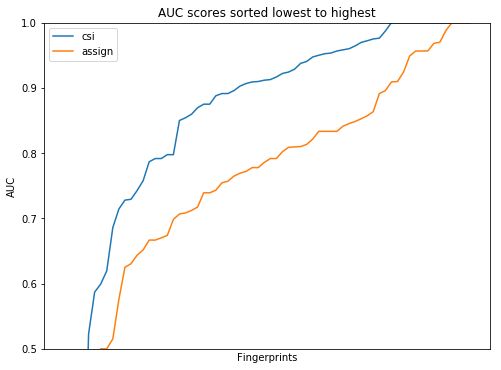

In [80]:
plt.title("AUC scores sorted lowest to highest")
plt.rcParams['figure.figsize'] = (8,6)
plt.plot(range(0, len(exp_aucs)), exp_aucs, label="csi")
plt.plot(range(0, len(base_aucs_correct)), base_aucs_correct, label="assign")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("AUC")
plt.ylim(0.5, 1)
plt.show()

In [33]:
wrong_assigned_trees = assign_to_tree(wrong_mol_names, wrong_folder_file)
print(wrong_assigned_trees.shape)

batch11 CCMSLIB00000001565
batch118 CCMSLIB00000072257
batch152 CCMSLIB00000072565
batch155 CCMSLIB00000075015
batch170 CCMSLIB00000075306
batch178 CCMSLIB00000075314
batch20 CCMSLIB00000001607
batch208 CCMSLIB00000078898
batch224 CCMSLIB00000081221
batch226 CCMSLIB00000081265
batch227 CCMSLIB00000081267
batch229 CCMSLIB00000081287
batch234 CCMSLIB00000204740
batch237 CCMSLIB00000223873
batch238 CCMSLIB00000223874
batch24 CCMSLIB00000001616
batch240 CCMSLIB00000223877
batch248 CCMSLIB00000223956
batch251 CCMSLIB00000223959
batch259 CCMSLIB00000424857
batch260 CCMSLIB00000424858
batch261 CCMSLIB00000424859
batch262 CCMSLIB00000424860
batch264 CCMSLIB00000424862
batch266 CCMSLIB00000424864
batch267 CCMSLIB00000424865
batch268 CCMSLIB00000424872
batch269 CCMSLIB00000424873
batch271 CCMSLIB00000424908
batch276 CCMSLIB00000424916
batch277 CCMSLIB00000424917
batch28 CCMSLIB00000001624
batch288 CCMSLIB00000427306
batch293 CCMSLIB00000478582
batch297 CCMSLIB00000478591
batch298 CCMSLIB00000478

In [34]:
wrong_fingerprints = load_fingerprints(wrong_assigned_trees.index, fingerprint_smarts)

In [35]:
wrong_assigned_trees.sort_index(inplace=True)
wrong_fingerprints.sort_index(inplace=True)

In [36]:
predicted = mod.predict(np.log(wrong_assigned_trees.values + 1))

In [37]:
assign_auc_wrong = compute_auc(wrong_fingerprints.columns.tolist(), wrong_fingerprints.values, predicted)

Compute AUC done


In [38]:
csi_fingerprints = load_csi_fingerprints(output_file_dir, wrong_folder_file)
csi_fingerprints.sort_index(inplace=True)
print(csi_fingerprints.shape)

(56, 154)


In [39]:
csi_correct_auc = compute_auc(wrong_fingerprints.columns.tolist(), wrong_fingerprints.values, csi_fingerprints.values)

Compute AUC done


In [40]:
differences = []
pvalues = []
base_aucs_wrong = []
exp_aucs = []

for i, auc in csi_correct_auc:
    difference = assign_auc_wrong[i][1] - auc # remove outliers

    if difference != 0:
        base_aucs_wrong.append(assign_auc_wrong[i][1])
        exp_aucs.append(auc)
        differences.append((i, difference))

t_test = stats.wilcoxon(base_aucs_wrong, exp_aucs)

print(t_test.pvalue)

2.9185154954349862e-06


In [41]:
base_aucs_wrong.sort()
exp_aucs.sort()

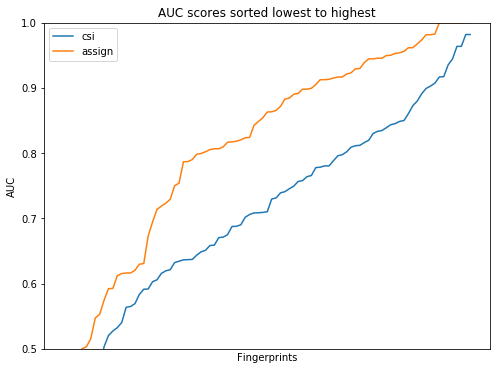

In [42]:
plt.title("AUC scores sorted lowest to highest")
plt.plot(range(0, len(exp_aucs)), exp_aucs, label="csi")
plt.plot(range(0, len(base_aucs_wrong)), base_aucs_wrong, label="assign")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("AUC")
plt.ylim(0.5, 1)
plt.show()

In [43]:
no_fingerprints_assigned_trees = assign_to_tree(no_fingerprints_mol_names, no_fingerprints_folder_file)
print(no_fingerprints_assigned_trees.shape)

batch1 CCMSLIB00000001550
batch10 CCMSLIB00000001564
batch100 CCMSLIB00000072149
batch101 CCMSLIB00000072176
batch102 CCMSLIB00000072177
batch103 CCMSLIB00000072178
batch104 CCMSLIB00000072179
batch105 CCMSLIB00000072181
batch106 CCMSLIB00000072182
batch107 CCMSLIB00000072183
batch108 CCMSLIB00000072185
batch109 CCMSLIB00000072186
batch112 CCMSLIB00000072246
batch113 CCMSLIB00000072247
batch114 CCMSLIB00000072248
batch115 CCMSLIB00000072249
batch116 CCMSLIB00000072255
batch117 CCMSLIB00000072256
batch119 CCMSLIB00000072258
batch12 CCMSLIB00000001567
batch120 CCMSLIB00000072259
batch121 CCMSLIB00000072260
batch125 CCMSLIB00000072264
batch127 CCMSLIB00000072266
batch128 CCMSLIB00000072267
batch129 CCMSLIB00000072268
batch13 CCMSLIB00000001569
batch130 CCMSLIB00000072269
batch132 CCMSLIB00000072271
batch134 CCMSLIB00000072273
batch136 CCMSLIB00000072275
batch137 CCMSLIB00000072284
batch138 CCMSLIB00000072285
batch139 CCMSLIB00000072286
batch14 CCMSLIB00000001571
batch140 CCMSLIB0000007228

In [44]:
no_fingerprints_fingerprints = load_fingerprints(no_fingerprints_assigned_trees.index, fingerprint_smarts)
no_fingerprints_fingerprints = no_fingerprints_fingerprints[no_fingerprints_fingerprints.index.isin(no_fingerprints_assigned_trees.index)]

In [45]:
no_fingerprints_assigned_trees.sort_index(inplace=True)
no_fingerprints_fingerprints.sort_index(inplace=True)

In [46]:
predicted = mod.predict(np.log(no_fingerprints_assigned_trees.values + 1))

In [47]:
assign_auc_empty = compute_auc(no_fingerprints_fingerprints.columns.tolist(), no_fingerprints_fingerprints.values, predicted)

Compute AUC done


In [48]:
print("Number of substructures that have AUC > 0.5 : {}".format(len([(index, auc) for index, auc in assign_auc_empty if auc>0.5])))

Number of substructures that have AUC > 0.5 : 102


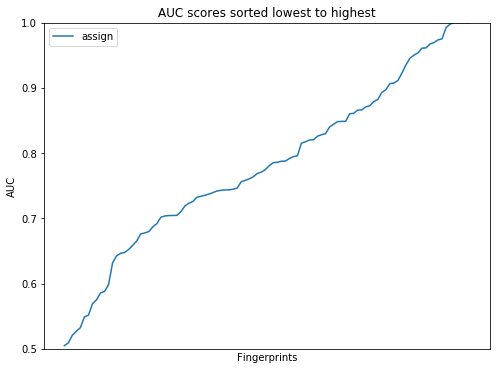

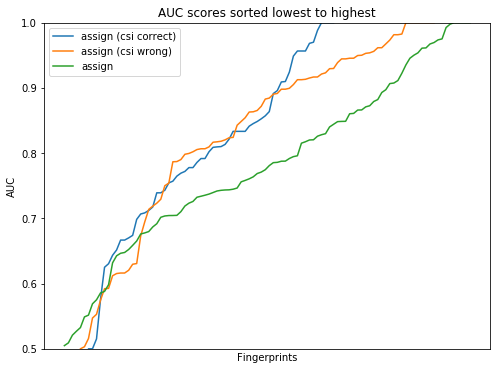

In [49]:
aucs_empty = [auc[1] for auc in assign_auc_empty if auc[1] - 0.5 > 0]

aucs_empty.sort()

plt.title("AUC scores sorted lowest to highest")
plt.plot(range(0, len(aucs_empty)), aucs_empty, label="assign")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("AUC")
plt.ylim(0.5, 1)
plt.show()

plt.title("AUC scores sorted lowest to highest")
plt.plot(range(0, len(base_aucs_correct)), base_aucs_correct, label="assign (csi correct)")
plt.plot(range(0, len(base_aucs_wrong)), base_aucs_wrong, label="assign (csi wrong)")
plt.plot(range(0, len(aucs_empty)), aucs_empty, label="assign")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("AUC")
plt.ylim(0.5, 1)
plt.show()

In [50]:
assigned_tree_with_known_ionization = pd.read_pickle(assigned_tree_known_ionization_path)
assigned_tree_with_known_ionization.sort_index(inplace=True)

print(assigned_tree_with_known_ionization)

                    BrH_loss  Br_loss         C10  C10H10  C10H10ClN  \
CCMSLIB00000001548       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001549       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001550       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001555       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001563       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001565       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001566       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001568       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001569       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001570       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001572       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001574       0.0      0.0    0.000000     0.0        0.0   
CCMSLIB00000001576       0.0      0.0    0.000000     0.0       

In [51]:
epochs = 100

mod_known_ion = baseline_model(assigned_tree_with_known_ionization, fingerprints)
preprocessed_assigned_tree_known_ion = np.log(assigned_tree_with_known_ionization.values+1)

history_known_ion = mod_known_ion.fit(preprocessed_assigned_tree_known_ion, fingerprints.values, epochs=epochs, validation_split=0.2, verbose=0)

In [52]:
mol_ionization = {}
ionization_string = ["MH", "MNa", "MK"]
count = 0

for file in os.listdir(mgf_batches_input):
    filepath = os.path.join(mgf_batches_input, file)
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith("FILENAME"):
                description, filename = line.split("=")
                default_ion = "H"
                found = False
                for ion_string in ionization_string:
                    if ion_string in filename:
                        default_ion = ion_string[1:]
                        found = True
                        
                if found:
                    count += 1
                        
                mol_ionization[file[:-4]] = default_ion
                
print("Matched {} adducts".format(count))

Matched 32 adducts


In [53]:
def assign_to_tree_known_ionization(mol_ids, folder_files):
    tree_intensities = pd.DataFrame(0.0, index=mol_ids, columns=combined_index, dtype=float)
        
    for folder_file in folder_files:
        if len(folder_file) > 2:
            directory, mol, formula, fpt_file = folder_file
        else:
            directory, mol = folder_file
            
        spec_path = output_file_dir + "\\" + directory + "\\1_{0}_{1}\\".format(directory, mol) + "spectrum.ms"
        if os.path.isfile(spec_path):
            split_count = 0
            assigned_formula_intensity = []
            with open(spec_path, 'r') as f:
                content = f.readlines()
                cursor = 0
                print(directory, mol)
                while not content[cursor].startswith(">ms2peaks"):
                    cursor += 1

                mass_intensity_list = convert_lines_to_list(content[cursor+1:])

                ionization = ion_mass[mol_ionization[directory]]

                for mass, intensity in mass_intensity_list:
                    non_ionized_mass = mass - ionization
                    mass_int, decimals = str(non_ionized_mass).split(".")
                    if int(mass_int) in fragment_mass_to_formula_dict:
                        chosen_bins = []
                        for full_mass, formula in fragment_mass_to_formula_dict[int(mass_int)].items():
                            if full_mass-0.025 <= non_ionized_mass <= full_mass+0.025: # within 0.05 width
                                chosen_bins.append(full_mass)

                        if len(chosen_bins) > 1:
                            nearest_bin_allocation, furthest_bin_allocation = assign_between_bins(chosen_bins)
                            tree_intensities.at[mol, fragment_mass_to_formula_dict[int(mass_int)][nearest_bin_allocation[0]]] += float(intensity) * nearest_bin_allocation[1]
                            tree_intensities.at[mol, fragment_mass_to_formula_dict[int(mass_int)][furthest_bin_allocation[0]]] += float(intensity) * furthest_bin_allocation[1]
                            assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][nearest_bin_allocation[0]], 
                                                               nearest_bin_allocation[0], intensity*nearest_bin_allocation[1]))
                            assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][furthest_bin_allocation[0]], 
                                                               furthest_bin_allocation[0], intensity*furthest_bin_allocation[1]))
                            split_count += 1

                        elif len(chosen_bins) == 1:
                            tree_intensities.at[mol, fragment_mass_to_formula_dict[int(mass_int)][chosen_bins[0]]] += float(intensity)
                            assigned_formula_intensity.append((fragment_mass_to_formula_dict[int(mass_int)][chosen_bins[0]], chosen_bins[0], intensity))

                        else:
                            continue

                assigned_formula_intensity.sort(key = lambda t: t[1])
                assigned_formula_intensity.reverse() # highest to smallest

                peak_differences = [(subtract_formula(formula_intensity_i[0], formula_intensity_j[0]) + "_loss", 
                                     (formula_intensity_i[2] + formula_intensity_j[2]) / 2.0 ) 
                                    for i, formula_intensity_i in enumerate(assigned_formula_intensity)
                                    for j, formula_intensity_j in enumerate(assigned_formula_intensity) 
                                    if i != j 
                                    and j > i
                                    and len(re.findall('[A-Z][a-z]*[0-9]*', formula_intensity_i[0])) >= len(re.findall('[A-Z][a-z]*[0-9]*', formula_intensity_j[0]))
                                    and subtract_formula(formula_intensity_i[0], formula_intensity_j[0]) + "_loss" in losses_df.index]

                for formula, intensity in peak_differences:
                    tree_intensities.at[mol, formula] += float(intensity)

                if np.amax(tree_intensities.loc[mol]) > 0:
                    tree_intensities.loc[mol] = tree_intensities.loc[mol].div(np.amax(tree_intensities.loc[mol].values)).mul(999)

        else:
            tree_intensities.drop(mol, inplace=True)
            
    return tree_intensities

In [54]:
correct_assigned_trees_known_ion = assign_to_tree_known_ionization(correct_mol_names, correct_folder_file)
correct_assigned_trees_known_ion.sort_index(inplace=True)
print(correct_assigned_trees_known_ion.shape)

batch110 CCMSLIB00000072234
batch111 CCMSLIB00000072237
batch172 CCMSLIB00000075308
batch19 CCMSLIB00000001606
batch236 CCMSLIB00000223870
batch239 CCMSLIB00000223876
batch246 CCMSLIB00000223902
batch25 CCMSLIB00000001621
batch254 CCMSLIB00000424790
batch27 CCMSLIB00000001623
batch278 CCMSLIB00000424918
batch279 CCMSLIB00000424925
batch286 CCMSLIB00000427300
batch287 CCMSLIB00000427303
batch29 CCMSLIB00000001625
batch294 CCMSLIB00000478584
batch299 CCMSLIB00000478593
batch302 CCMSLIB00000478652
batch308 CCMSLIB00000531504
batch314 CCMSLIB00000539139
batch32 CCMSLIB00000001645
batch343 CCMSLIB00000006292
batch348 CCMSLIB00000077108
batch350 CCMSLIB00000077134
batch77 CCMSLIB00000072062
(25, 5508)


In [55]:
predicted = mod_known_ion.predict(np.log(correct_assigned_trees_known_ion.values + 1))

In [56]:
assign_known_ion_auc_correct = compute_auc(correct_fingerprints.columns.tolist(), correct_fingerprints.values, predicted)

Compute AUC done


In [57]:
differences = []
pvalues = []
base_aucs_correct_known = []
exp_aucs = []

for i, auc in csi_correct_auc:
    difference = assign_known_ion_auc_correct[i][1] - auc # remove outliers

    if difference != 0:
        base_aucs_correct_known.append(assign_known_ion_auc_correct[i][1])
        exp_aucs.append(auc)
        differences.append((i, difference))

t_test = stats.wilcoxon(base_aucs_correct_known, exp_aucs)

print(t_test.pvalue)

0.3395792160724411


In [58]:
base_aucs_correct_known.sort()
exp_aucs.sort()

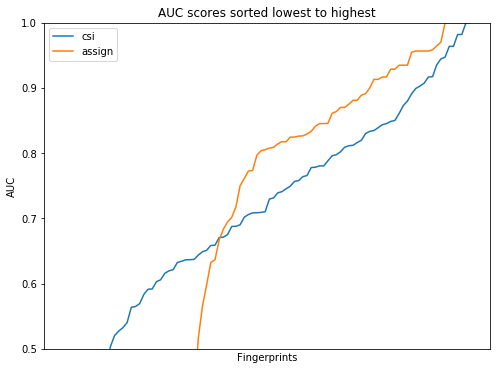

In [59]:
plt.title("AUC scores sorted lowest to highest")
plt.plot(range(0, len(exp_aucs)), exp_aucs, label="csi")
plt.plot(range(0, len(base_aucs_correct_known)), base_aucs_correct_known, label="assign")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("AUC")
plt.ylim(0.5, 1)
plt.show()

In [60]:
wrong_assigned_trees_known_ion = assign_to_tree_known_ionization(wrong_mol_names, wrong_folder_file)
wrong_assigned_trees_known_ion.sort_index(inplace=True)
print(wrong_assigned_trees_known_ion.shape)

batch11 CCMSLIB00000001565
batch118 CCMSLIB00000072257
batch152 CCMSLIB00000072565
batch155 CCMSLIB00000075015
batch170 CCMSLIB00000075306
batch178 CCMSLIB00000075314
batch20 CCMSLIB00000001607
batch208 CCMSLIB00000078898
batch224 CCMSLIB00000081221
batch226 CCMSLIB00000081265
batch227 CCMSLIB00000081267
batch229 CCMSLIB00000081287
batch234 CCMSLIB00000204740
batch237 CCMSLIB00000223873
batch238 CCMSLIB00000223874
batch24 CCMSLIB00000001616
batch240 CCMSLIB00000223877
batch248 CCMSLIB00000223956
batch251 CCMSLIB00000223959
batch259 CCMSLIB00000424857
batch260 CCMSLIB00000424858
batch261 CCMSLIB00000424859
batch262 CCMSLIB00000424860
batch264 CCMSLIB00000424862
batch266 CCMSLIB00000424864
batch267 CCMSLIB00000424865
batch268 CCMSLIB00000424872
batch269 CCMSLIB00000424873
batch271 CCMSLIB00000424908
batch276 CCMSLIB00000424916
batch277 CCMSLIB00000424917
batch28 CCMSLIB00000001624
batch288 CCMSLIB00000427306
batch293 CCMSLIB00000478582
batch297 CCMSLIB00000478591
batch298 CCMSLIB00000478

In [61]:
predicted = mod_known_ion.predict(np.log(wrong_assigned_trees_known_ion.values + 1))

In [62]:
assign_known_ion_auc_wrong = compute_auc(wrong_fingerprints.columns.tolist(), wrong_fingerprints.values, predicted)

Compute AUC done


In [63]:
differences = []
pvalues = []
base_aucs_wrong_known = []
exp_aucs = []

for i, auc in csi_correct_auc:
    difference = assign_known_ion_auc_wrong[i][1] - auc # remove outliers

    if difference != 0:
        base_aucs_wrong_known.append(assign_known_ion_auc_wrong[i][1])
        exp_aucs.append(auc)
        differences.append((i, difference))

t_test = stats.wilcoxon(base_aucs_wrong_known, exp_aucs)

print(t_test.pvalue)

1.5318666460820962e-06


In [64]:
base_aucs_wrong_known.sort()
exp_aucs.sort()

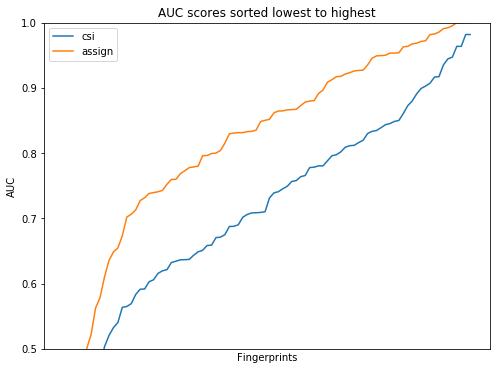

In [65]:
plt.title("AUC scores sorted lowest to highest")
plt.plot(range(0, len(exp_aucs)), exp_aucs, label="csi")
plt.plot(range(0, len(base_aucs_wrong_known)), base_aucs_wrong_known, label="assign")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("AUC")
plt.ylim(0.5, 1)
plt.show()

In [66]:
no_fingerprints_assigned_trees_known_ion = assign_to_tree_known_ionization(no_fingerprints_mol_names, no_fingerprints_folder_file)
no_fingerprints_assigned_trees_known_ion.sort_index(inplace=True)
print(no_fingerprints_assigned_trees_known_ion.shape)

batch1 CCMSLIB00000001550
batch10 CCMSLIB00000001564
batch100 CCMSLIB00000072149
batch101 CCMSLIB00000072176
batch102 CCMSLIB00000072177
batch103 CCMSLIB00000072178
batch104 CCMSLIB00000072179
batch105 CCMSLIB00000072181
batch106 CCMSLIB00000072182
batch107 CCMSLIB00000072183
batch108 CCMSLIB00000072185
batch109 CCMSLIB00000072186
batch112 CCMSLIB00000072246
batch113 CCMSLIB00000072247
batch114 CCMSLIB00000072248
batch115 CCMSLIB00000072249
batch116 CCMSLIB00000072255
batch117 CCMSLIB00000072256
batch119 CCMSLIB00000072258
batch12 CCMSLIB00000001567
batch120 CCMSLIB00000072259
batch121 CCMSLIB00000072260
batch125 CCMSLIB00000072264
batch127 CCMSLIB00000072266
batch128 CCMSLIB00000072267
batch129 CCMSLIB00000072268
batch13 CCMSLIB00000001569
batch130 CCMSLIB00000072269
batch132 CCMSLIB00000072271
batch134 CCMSLIB00000072273
batch136 CCMSLIB00000072275
batch137 CCMSLIB00000072284
batch138 CCMSLIB00000072285
batch139 CCMSLIB00000072286
batch14 CCMSLIB00000001571
batch140 CCMSLIB0000007228

In [67]:
predicted = mod_known_ion.predict(np.log(no_fingerprints_assigned_trees_known_ion.values + 1))

In [68]:
assign_auc_known_empty = compute_auc(no_fingerprints_fingerprints.columns.tolist(), no_fingerprints_fingerprints.values, predicted)

Compute AUC done


In [69]:
print("Number of substructures that have AUC > 0.5 : {}".format(len([(index, auc) for index, auc in assign_auc_known_empty if auc>0.5])))

Number of substructures that have AUC > 0.5 : 103


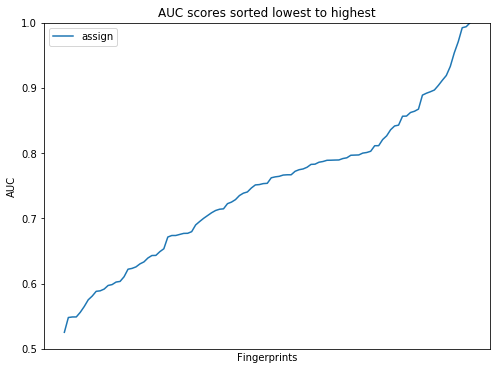

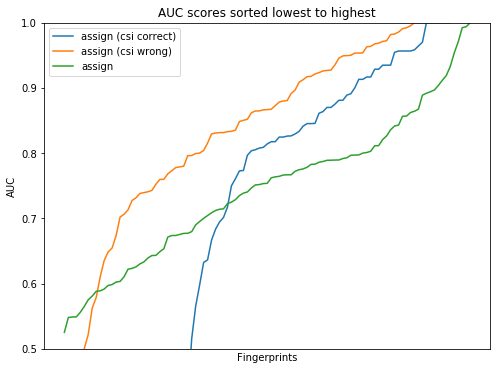

In [70]:
aucs_known_empty = [auc[1] for auc in assign_auc_known_empty if auc[1] - 0.5 > 0]

aucs_known_empty.sort()

plt.title("AUC scores sorted lowest to highest")
plt.plot(range(0, len(aucs_known_empty)), aucs_known_empty, label="assign")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("AUC")
plt.ylim(0.5, 1)
plt.show()

plt.title("AUC scores sorted lowest to highest")
plt.plot(range(0, len(base_aucs_correct_known)), base_aucs_correct_known, label="assign (csi correct)")
plt.plot(range(0, len(base_aucs_wrong_known)), base_aucs_wrong_known, label="assign (csi wrong)")
plt.plot(range(0, len(aucs_known_empty)), aucs_known_empty, label="assign")

plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("AUC")
plt.ylim(0.5, 1)
plt.show()